In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv("Nat_gas.csv")
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df = df.sort_values('Dates').set_index('Dates')
df.index = df.index.to_period('M').to_timestamp('M')
df = df[['Prices']]

In [4]:
seasonal_type = 'mul' if len(df) >= 24 else 'add'
model = ExponentialSmoothing(df['Prices'], trend='add', seasonal=seasonal_type, seasonal_periods=12)
fit = model.fit(optimized=True)

In [5]:
forecast_periods = 12
future_idx = pd.period_range(df.index[-1].to_period('M') + 1, periods=forecast_periods, freq='M').to_timestamp('M')
forecast = fit.forecast(forecast_periods)
forecast.index = future_idx

In [6]:
modeled = pd.concat([df['Prices'], forecast])
modeled = modeled.rename('modeled')

In [7]:
daily_index = pd.date_range(modeled.index.min(), modeled.index.max(), freq='D')
daily_curve = modeled.reindex(daily_index.union(modeled.index)).sort_index().interpolate(method='time').reindex(daily_index)

In [8]:
resid = df['Prices'] - fit.fittedvalues
sigma = resid.std()
daily_upper = daily_curve.copy()
daily_lower = daily_curve.copy()
daily_upper.loc[future_idx[0]:] += 1.96*sigma
daily_lower.loc[future_idx[0]:] -= 1.96*sigma

In [9]:
def get_price_estimate(query_date, daily_curve, daily_lower=None, daily_upper=None):
    query_date = pd.to_datetime(query_date)
    if query_date in daily_curve.index:
        price = daily_curve.loc[query_date]
        if daily_lower is not None and daily_upper is not None:
            return price, daily_lower.loc[query_date], daily_upper.loc[query_date]
        return price
    else:
        return None

In [10]:
get_price_estimate("2024-11-15", daily_curve, daily_lower, daily_upper)

(12.40152336473989, 12.089063289042832, 12.71398344043695)

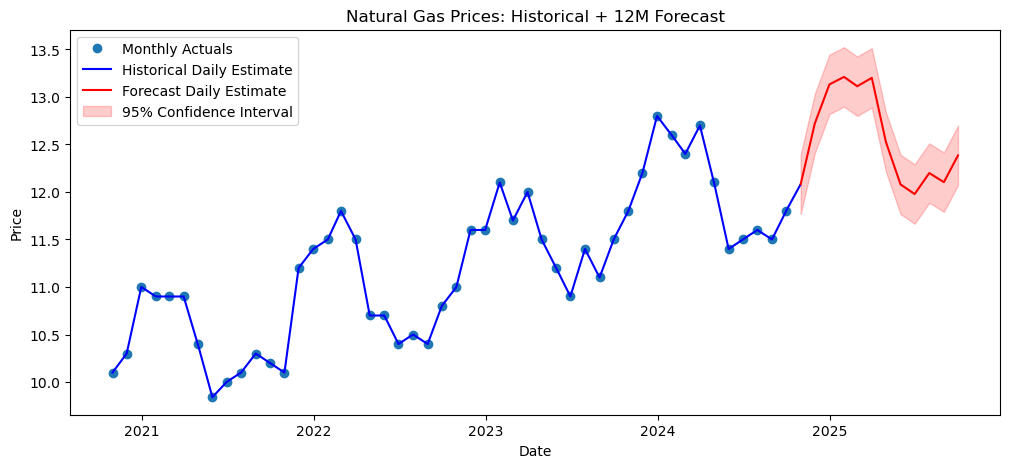

In [11]:
plt.figure(figsize=(12,5))

plt.plot(df.index, df['Prices'], 'o', label='Monthly Actuals')

plt.plot(daily_curve.index[daily_curve.index < future_idx[0]], 
         daily_curve[daily_curve.index < future_idx[0]], 
         color='blue', label='Historical Daily Estimate')

plt.plot(daily_curve.index[daily_curve.index >= future_idx[0]],
         daily_curve[daily_curve.index >= future_idx[0]],
         color='red', label='Forecast Daily Estimate')

plt.fill_between(daily_curve.index[daily_curve.index >= future_idx[0]],
                 daily_lower[daily_curve.index >= future_idx[0]],
                 daily_upper[daily_curve.index >= future_idx[0]],
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.title("Natural Gas Prices: Historical + 12M Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()